In [1]:
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])



# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


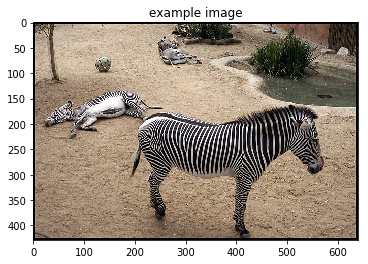

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

orig_image, image = next(iter(data_loader))

plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

In [7]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
% load_ext autoreload
% autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

encoder_file = "encoder-4.pkl" 
decoder_file = "decoder-4.pkl"

embed_size = 256
hidden_size = 512

vocab_size = len(data_loader.dataset.vocab)

encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

encoder.to(device)
decoder.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:03<00:00, 31441081.32it/s]


DecoderRNN(
  (embed): Embedding(8855, 256)
  (lstm): LSTM(256, 512, num_layers=3, batch_first=True, dropout=0.4)
  (linear): Linear(in_features=512, out_features=8855, bias=True)
)

In [9]:
image = image.to(device)

features = encoder(image).unsqueeze(1)

output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

example output: [0, 3, 1835, 170, 364, 161, 3, 1835, 77, 3, 1656, 1674, 18, 1, 1, 18, 1, 1, 18, 1]


In [10]:
def clean_sentence(output):
    sentence = ""
    for word_token in output:
        if word_token == 0 or word_token == 1 or word_token ==2:
            continue
        sentence += (data_loader.dataset.vocab.idx2word[word_token] + " ")
    
    return sentence

In [11]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: a zebra standing next to a zebra in a zoo enclosure . . . 


In [12]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

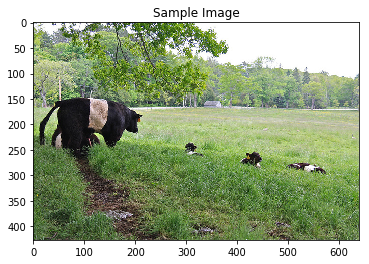

a group of cows grazing in a field . . . . 


In [25]:
get_prediction()

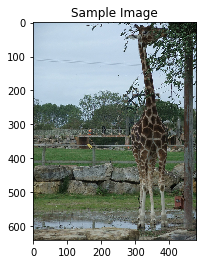

a giraffe standing next to a tree in a zoo . . . 


In [29]:
get_prediction()

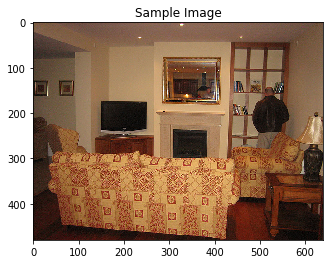

a living room with a couch and a television . . 


In [32]:
get_prediction()

### The model could have performed better ...

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively inaccurate captions.

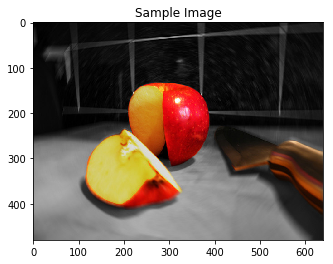

a bowl of oranges and a banana on a table . . . 


In [34]:
get_prediction()

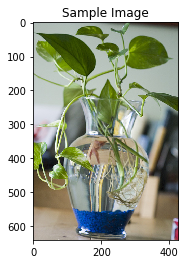

a vase filled with flowers on a table . . . . 


In [35]:
get_prediction()

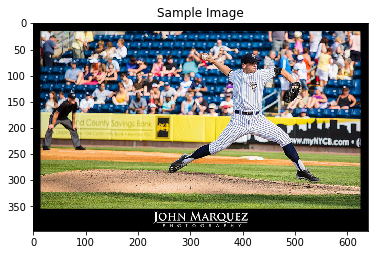

a baseball player swinging a bat at a ball . . . 


In [36]:
get_prediction()